# HistGradientBoostingRegressor

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor,HistGradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


## we select the following four features for this task.

In [50]:
# select features we want
features = ['reanalysis_specific_humidity_g_per_kg', 
                'reanalysis_dew_point_temp_k', 
                'station_avg_temp_c', 
                'station_min_temp_c']

Now that we've explored this data, it's time to start modeling. Our first step will be to build a function that does all of the preprocessing we've done above from start to finish. This will make our lives easier, since it needs to be applied to the test set and the traning set before we make our predictions.

In [51]:
def preprocess_data(data_path, features, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2,3])
    
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [52]:
sj_train, iq_train = preprocess_data('./dengue_features_train.csv',
                                    features=features,
                                    labels_path="./dengue_labels_train.csv")

C:\Users\cxf20\AppData\Local\Temp\ipykernel_28976\3271642535.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Now we can take a look at the smaller dataset and see that it's ready to start modelling:

In [53]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.547535,295.104736,26.999191,22.594017,34.180556
std,1.560663,1.570075,1.415079,1.506281,51.381372
min,11.715714,289.642857,22.842857,17.800000,0.000000
25%,15.233571,293.843929,25.842857,21.700000,9.000000
50%,16.835000,295.451429,27.214286,22.800000,19.000000
75%,17.854286,296.415714,28.175000,23.900000,37.000000
max,19.440000,297.795714,30.071429,25.600000,461.000000


In [54]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.102019,295.498723,27.506331,21.210385,7.565385
std,1.443048,1.414360,0.908973,1.257734,10.765478
min,12.111429,290.088571,21.400000,14.700000,0.000000
25%,16.121429,294.596429,26.957500,20.600000,1.000000
50%,17.428571,295.852143,27.587500,21.400000,5.000000
75%,18.180357,296.557143,28.075000,22.000000,9.000000
max,20.461429,298.450000,30.800000,24.200000,116.000000


Since this is a timeseries model, we'll use a strict-future holdout set when we are splitting our train set and our test set. We'll keep around three quarters of the original data for training and use the rest to test. We'll do this separately for our San Juan model and for our Iquitos model.

In [55]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [56]:
sj_train_subtest=sj_train_subtest[sj_train_subtest['total_cases']!=0]
iq_train_subtest=iq_train_subtest[iq_train_subtest['total_cases']!=0]

In [57]:
# Extract the parameter columns
X_train = sj_train_subtrain[features]

# Extract the label column
y_train = sj_train_subtrain['total_cases']

# Extract the parameter columns
X_test = sj_train_subtest[features]

# Extract the label column
y_test = sj_train_subtest['total_cases']



In [58]:
X_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c
count,800.000000,800.000000,800.000000,800.000000
mean,16.550268,295.107729,27.019929,22.588500
std,1.555026,1.568636,1.389155,1.517736
min,11.715714,289.642857,22.842857,17.800000
25%,15.257143,293.883929,25.882143,21.700000
50%,16.835000,295.447143,27.257143,22.800000
75%,17.845714,296.400000,28.160714,23.900000
max,19.207143,297.598571,30.071429,25.600000


In [59]:
y_train.describe()

count    800.000000
mean      35.863750
std       54.044483
min        0.000000
25%       10.000000
50%       20.000000
75%       38.000000
max      461.000000
Name: total_cases, dtype: float64

# HistGradientBoostingRegressor

In [60]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
def MAPE(data_true, data_pre):#平均百分比误差率评估
    data_true, data_pre = np.array(data_true), np.array(data_pre)
    print(data_true)
    return np.mean(np.abs((data_true - data_pre) / data_true)) * 100
def main(X_train, y_train, X_test, y_test):
    # scale
    maes=[]
    mapes=[]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # grid search
    loss_params = ['squared_error', 'absolute_error', 'poisson']
    lr_params = [0.1, 0.15, 0.05, 0.01]
    best_mae = 1000
    best_mape=1000
    best_pred=1000
    for loss in loss_params:
        for lr in lr_params:
            #  build Hist Gradient Boosting Regressor model
            model = HistGradientBoostingRegressor(loss=loss, learning_rate=lr)

            model.fit(X_train, y_train)

            # testing
            y_pred = model.predict(X_test)
            y_pred[y_pred<0] = 0
            y_pred = np.round(y_pred).astype(int)


            print(np.max(y_pred),np.min(y_pred),np.mean(y_pred))
            print(np.max(y_test),np.min(y_test),np.mean(y_test))
            # compute MAE  
            mae = mean_absolute_error(y_test, y_pred) 
            maes.append([loss+'+'+str(lr),mae])
            mape = mean_absolute_percentage_error(y_test, y_pred) 
            print(mape)
            mapes.append([loss+'+'+str(lr),mape])
            if mae < best_mae:
                best_mae = mae
                best_pred=y_pred
            if mape < best_mape:
                best_mape = mape
                
    print(f'Best Mean Absolute Error (MAE): {best_mae}')  
    print(f'Best Mean Absolute PENCENTAGE Error (MAPE): {best_mape}')
    return maes,mapes,best_mae,best_mape,best_pred

In [61]:
# Extract the parameter columns
X_train = sj_train_subtrain[features]

# Extract the label column
y_train = sj_train_subtrain['total_cases']

# Extract the parameter columns
X_test = sj_train_subtest[features]

# Extract the label column
y_test = sj_train_subtest['total_cases']

In [62]:
maes,mapes,best_sj_mae_hist,best_sj_mape_hist,best_pred=main(X_train, y_train, X_test, y_test)

153 0 38.11851851851852
170 1 24.45925925925926
3.539740917910948
159 0 38.18518518518518
170 1 24.45925925925926
3.5005443925241124
134 4 37.20740740740741
170 1 24.45925925925926
3.4299662961086677
89 19 34.56296296296296
170 1 24.45925925925926
3.328751001137456
61 4 24.57037037037037
170 1 24.45925925925926
2.0503163483597646
66 2 25.25925925925926
170 1 24.45925925925926
2.1186679727642708
63 5 24.16296296296296
170 1 24.45925925925926
1.975312227772342
37 11 22.177777777777777
170 1 24.45925925925926
1.952706456065571
220 6 36.49629629629629
170 1 24.45925925925926
3.249085528315052
164 6 35.74074074074074
170 1 24.45925925925926
3.09511206044044
164 9 36.34074074074074
170 1 24.45925925925926
3.2495294393311562
85 20 35.11851851851852
170 1 24.45925925925926
3.457662389623348
Best Mean Absolute Error (MAE): 18.474074074074075
Best Mean Absolute PENCENTAGE Error (MAPE): 1.952706456065571


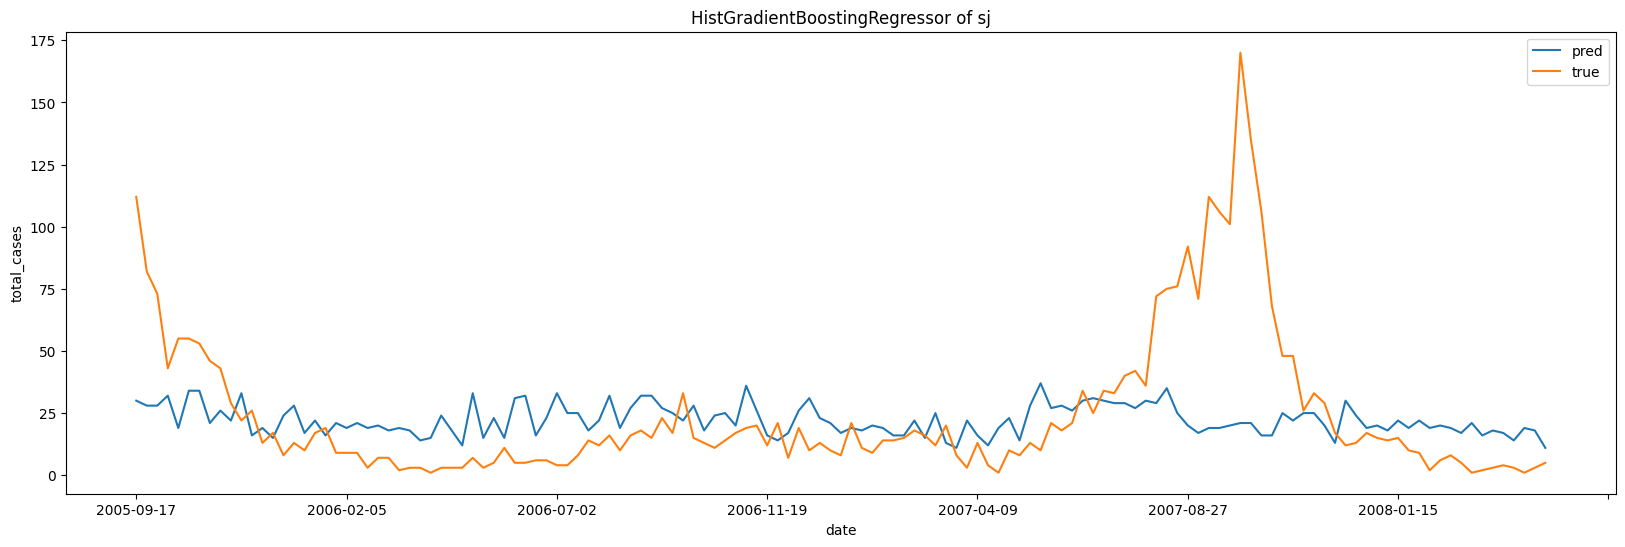

In [63]:
import matplotlib.pyplot as plt
time=[i[2] for i in list(sj_train_subtest.index)]
time_trend=pd.DataFrame()
time_trend['pred']=best_pred
time_trend['true']=list(y_test)
time_trend.index=time
time_trend['pred'].plot(figsize=(20,6))
time_trend['true'].plot(figsize=(20,6))
plt.xlabel('date')
plt.ylabel('total_cases')
plt.title('HistGradientBoostingRegressor of sj')
plt.legend()
plt.show()

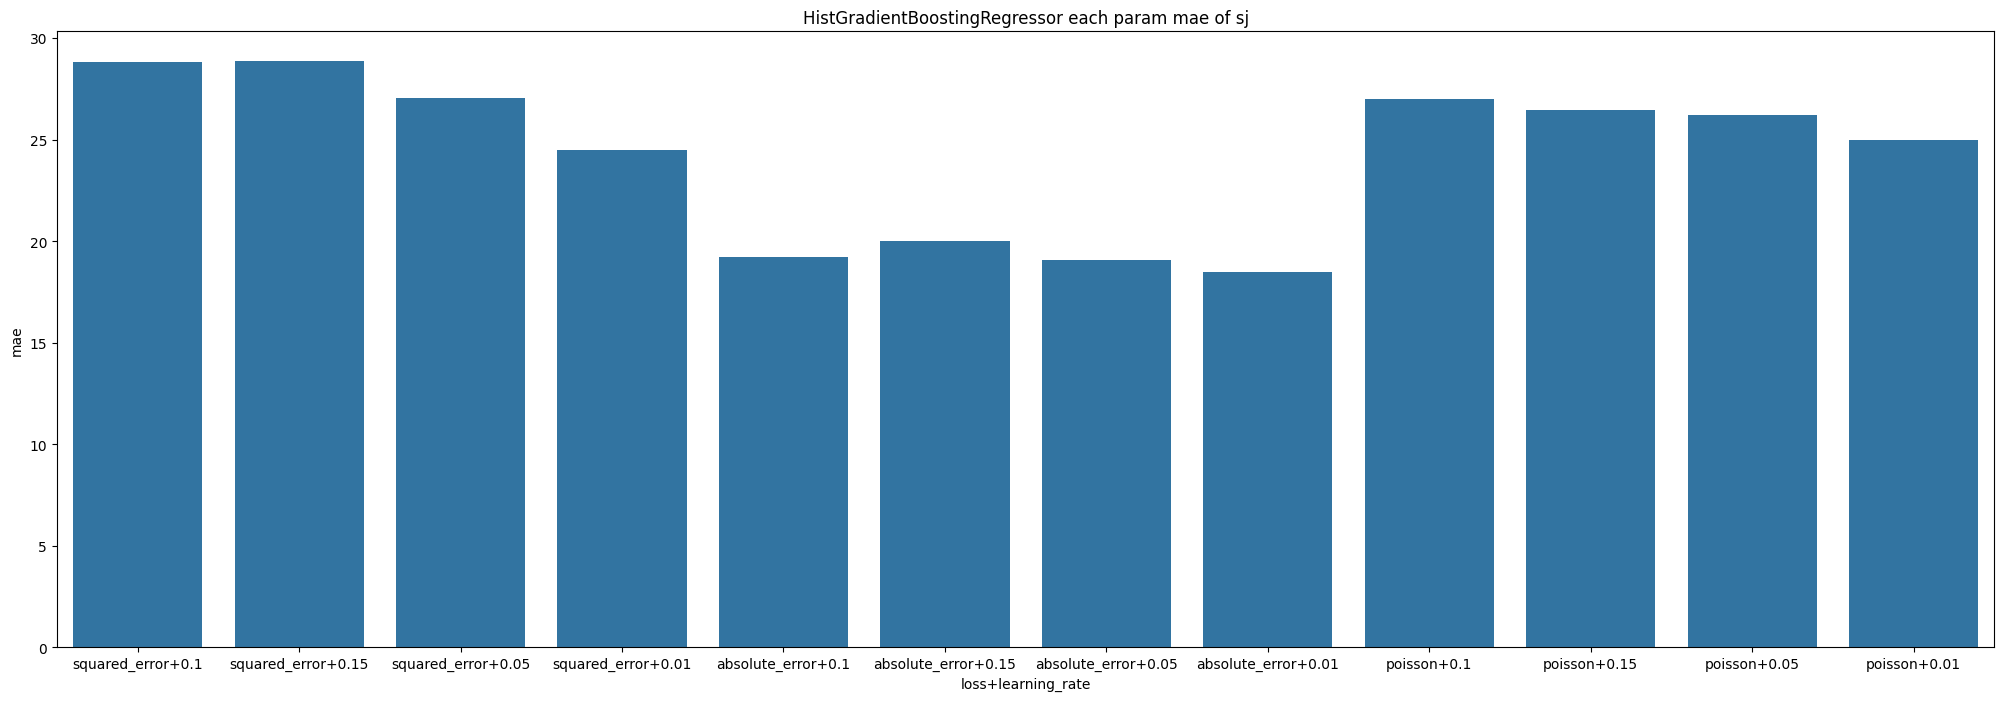

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in maes],y=[i[1] for i in maes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mae')
plt.title('HistGradientBoostingRegressor each param mae of sj')
plt.show()

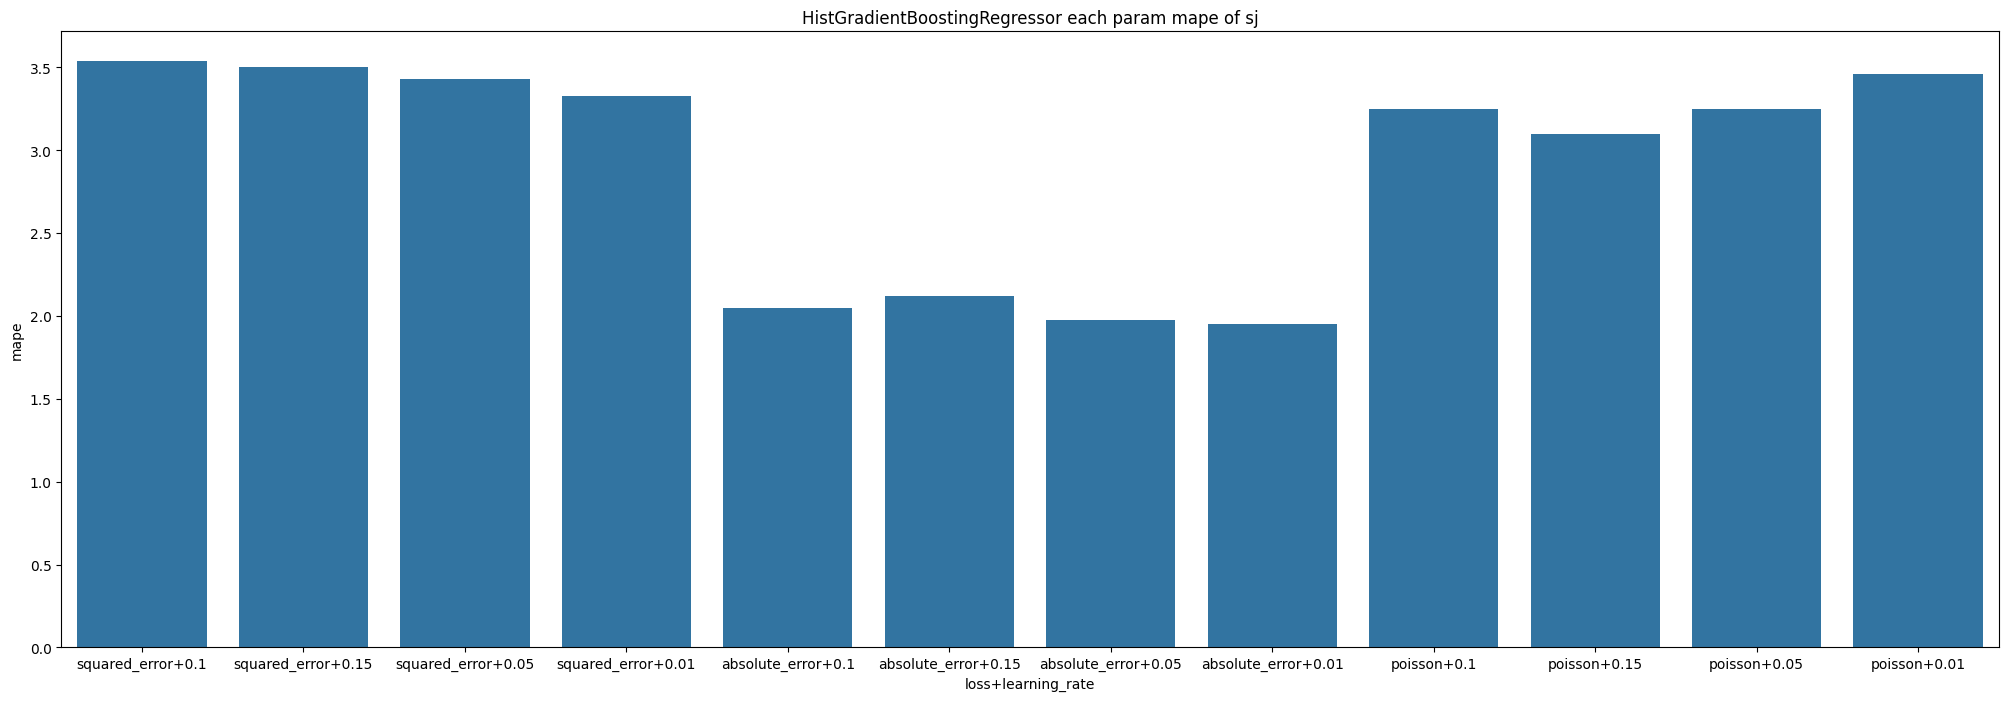

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in mapes],y=[i[1] for i in mapes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mape')
plt.title('HistGradientBoostingRegressor each param mape of sj')
plt.show()

In [66]:
# Extract the parameter columns
X_train = iq_train_subtrain[features]

# Extract the label column
y_train = iq_train_subtrain['total_cases']

# Extract the parameter columns
X_test = iq_train_subtest[features]

# Extract the label column
y_test = iq_train_subtest['total_cases']

In [67]:
maes,mapes,best_iq_mae_hist,best_iq_mape_hist,best_pred=main(X_train, y_train, X_test, y_test)

44 0 6.7889908256880735
63 1 9.431192660550458
1.7587338151427065
52 0 7.146788990825688
63 1 9.431192660550458
1.874027100084002
34 0 6.73394495412844
63 1 9.431192660550458
1.6628453242659422
18 3 6.91743119266055
63 1 9.431192660550458
1.51243251417686
13 0 4.513761467889908
63 1 9.431192660550458
1.058552132362579
13 0 4.513761467889908
63 1 9.431192660550458
1.0182144644628055
11 0 4.4495412844036695
63 1 9.431192660550458
1.0205466257992573
8 2 4.587155963302752
63 1 9.431192660550458
0.9480383623490647
44 1 6.165137614678899
63 1 9.431192660550458
1.504544695424884
46 0 6.045871559633028
63 1 9.431192660550458
1.4800112252804996
45 1 6.348623853211009
63 1 9.431192660550458
1.5490740034714343
21 4 6.862385321100917
63 1 9.431192660550458
1.4927631147222347
Best Mean Absolute Error (MAE): 6.770642201834862
Best Mean Absolute PENCENTAGE Error (MAPE): 0.9480383623490647


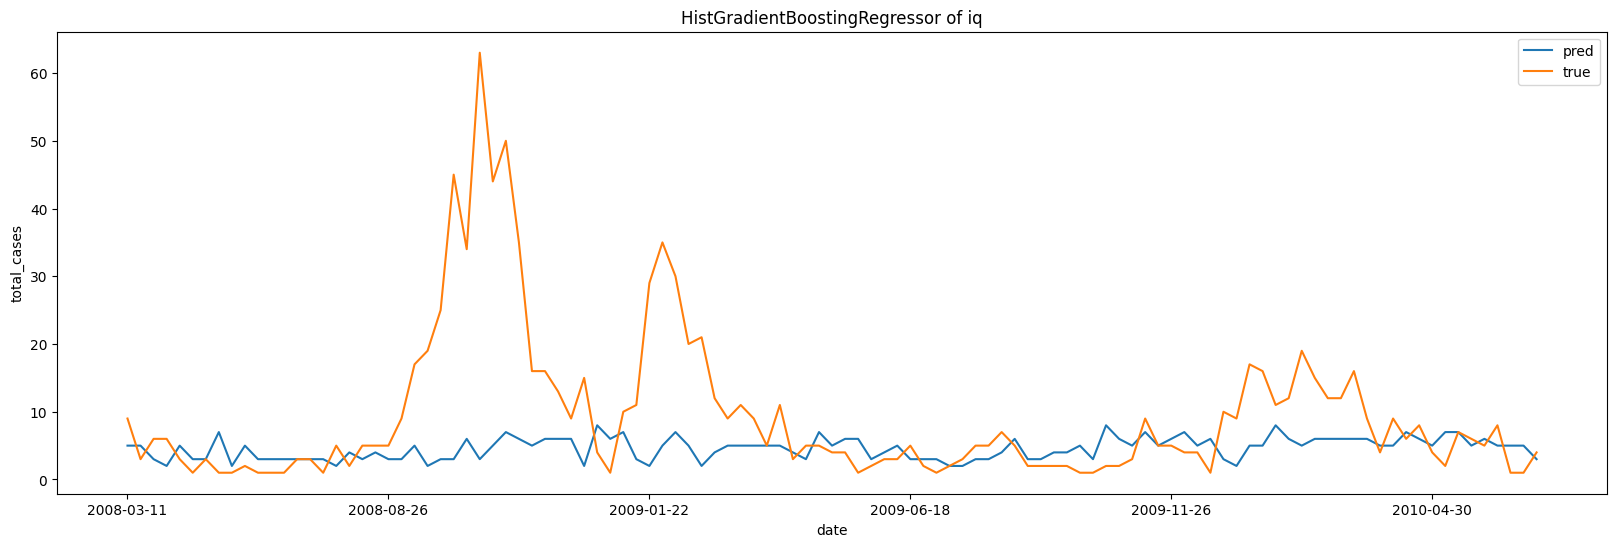

In [68]:
time=[i[2] for i in list(iq_train_subtest.index)]
time_trend=pd.DataFrame()
time_trend['pred']=best_pred
time_trend['true']=list(y_test)
time_trend.index=time
time_trend['pred'].plot(figsize=(20,6))
time_trend['true'].plot(figsize=(20,6))
plt.xlabel('date')
plt.ylabel('total_cases')
plt.title('HistGradientBoostingRegressor of iq')
plt.legend()
plt.show()

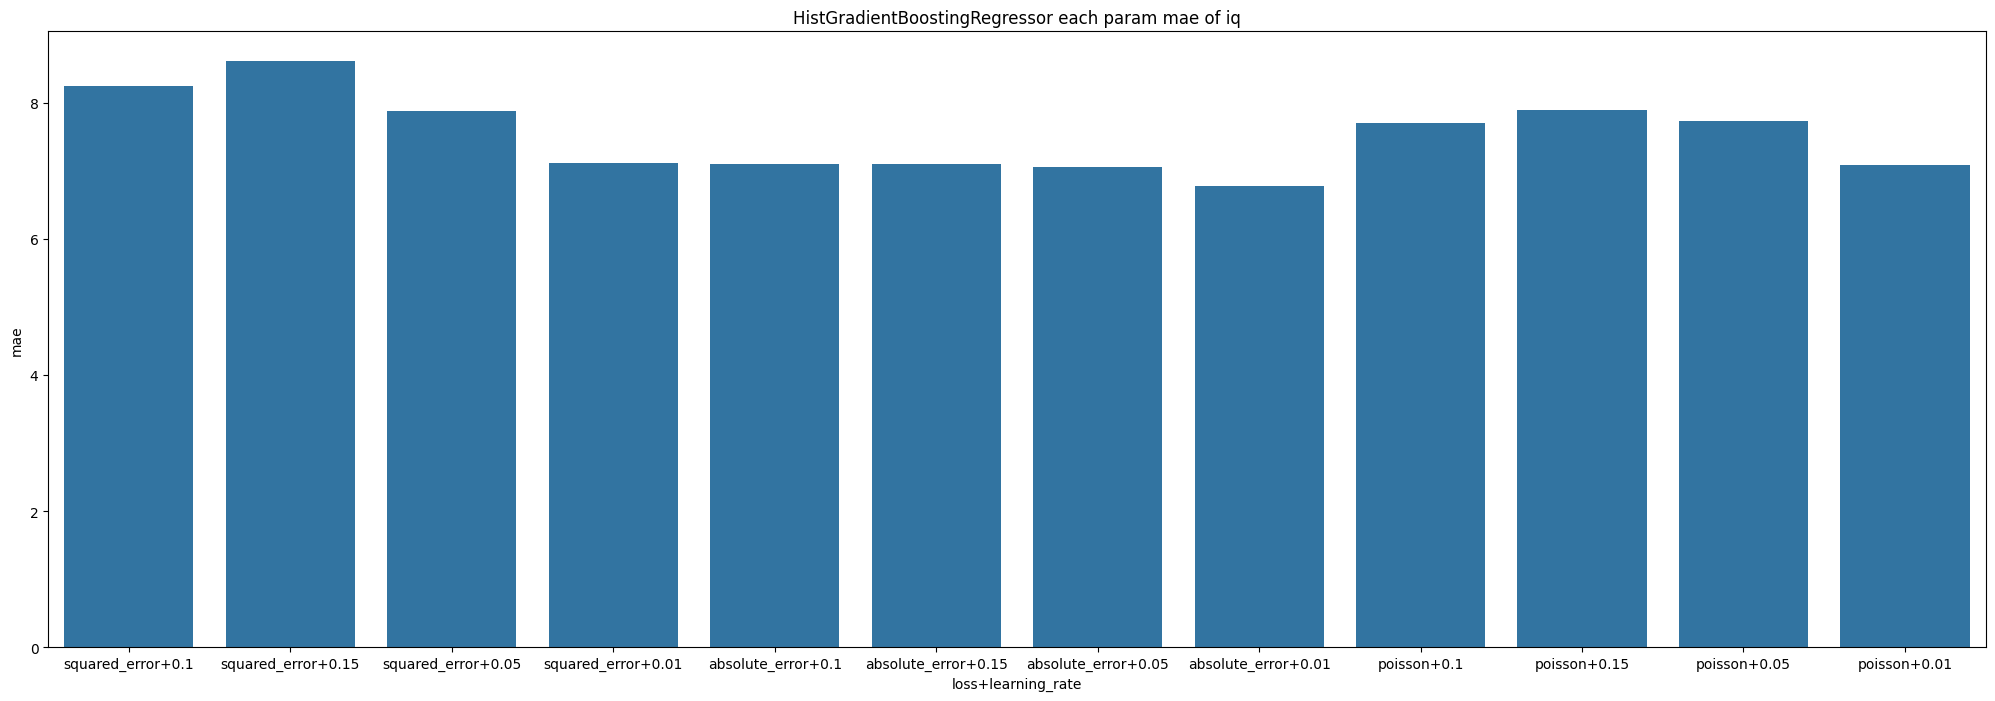

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in maes],y=[i[1] for i in maes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mae')
plt.title('HistGradientBoostingRegressor each param mae of iq')
plt.show()

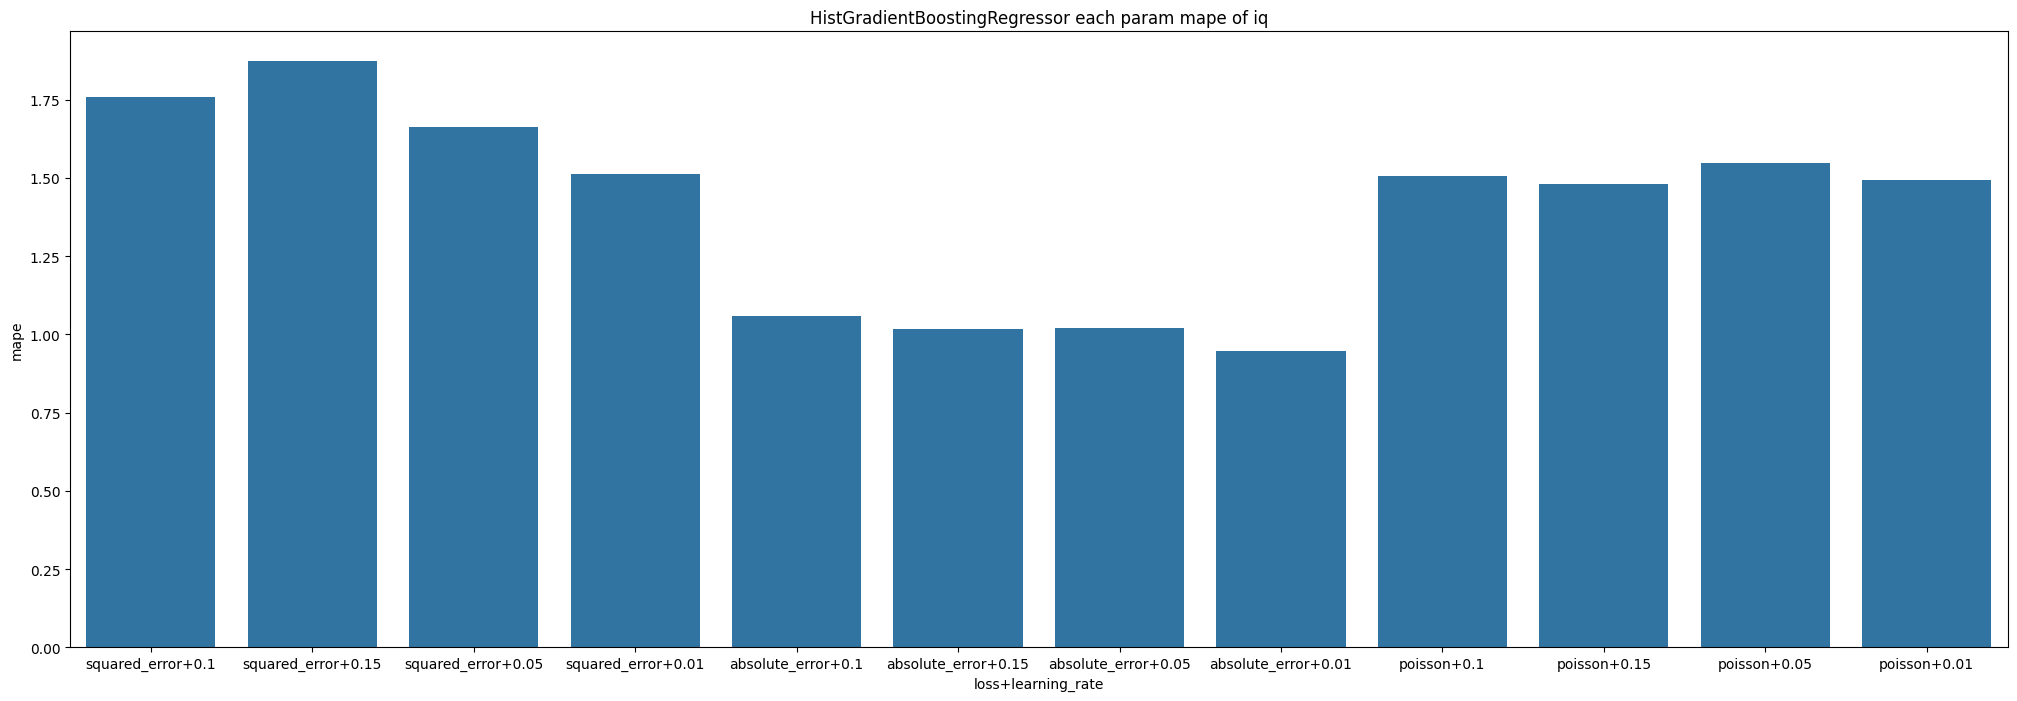

In [70]:
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in mapes],y=[i[1] for i in mapes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mape')
plt.title('HistGradientBoostingRegressor each param mape of iq')
plt.show()

# GradientBoostingRegressor

In [71]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import numpy as np

def main(X_train, y_train, X_test, y_test):
    # scale
    maes=[]
    mapes=[]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # grid search
    loss_params = ['squared_error', 'absolute_error', 'huber']
    lr_params = [0.1, 0.15, 0.05, 0.01]
    best_mae = 1000
    best_mape=1000
    best_pred=1000
    for loss in loss_params:
        for lr in lr_params:
            # build Gradient Boosting Regressor model
            model = GradientBoostingRegressor(loss=loss, learning_rate=lr)

            model.fit(X_train, y_train)

            # testing
            y_pred = model.predict(X_test)
            y_pred[y_pred<0] = 0
            y_pred = np.round(y_pred).astype(int)

            print(np.max(y_pred),np.min(y_pred),np.mean(y_pred))
            print(np.max(y_test),np.min(y_test),np.mean(y_test))
            
            # compute MAE  
            mae = mean_absolute_error(y_test, y_pred)  
            mape = mean_absolute_percentage_error(y_test, y_pred) 
            print(mape)
            maes.append([loss+'+'+str(lr),mae])
            mapes.append([loss+'+'+str(lr),mape])
            if mae < best_mae:
                best_mae = mae
                best_pred=y_pred
            if mape < best_mape:
                best_mape = mape
    print(f'Best Mean Absolute Error (MAE): {best_mae}')  
    print(f'Best Mean Absolute PENCENTAGE Error (MAPE): {best_mape}')  
    return maes,mapes,best_mae,best_mape,best_pred

In [72]:
# Extract the parameter columns
X_train = sj_train_subtrain[features]

# Extract the label column
y_train = sj_train_subtrain['total_cases']

# Extract the parameter columns
X_test = sj_train_subtest[features]

# Extract the label column
y_test = sj_train_subtest['total_cases']

In [73]:
maes,mapes,best_sj_mae_gbt,best_sj_mape_gbt,best_pred=main(X_train, y_train, X_test, y_test)

144 8 34.75555555555555
170 1 24.45925925925926
3.1725399805773415
213 8 36.60740740740741
170 1 24.45925925925926
3.6530339303409542
132 13 34.94814814814815
170 1 24.45925925925926
3.160118409150424
64 22 34.733333333333334
170 1 24.45925925925926
3.3704551782732617
62 8 21.096296296296295
170 1 24.45925925925926
1.7099586473678183
50 9 20.918518518518518
170 1 24.45925925925926
1.720607316931442
39 11 20.474074074074075
170 1 24.45925925925926
1.7536718398088949
34 17 20.748148148148147
170 1 24.45925925925926
1.8841611035085033
147 9 29.4
170 1 24.45925925925926
2.405168273969951
155 7 29.77037037037037
170 1 24.45925925925926
2.36463546735775
137 11 28.59259259259259
170 1 24.45925925925926
2.472360986700238
65 15 24.94074074074074
170 1 24.45925925925926
2.2601504781185944
Best Mean Absolute Error (MAE): 17.451851851851853
Best Mean Absolute PENCENTAGE Error (MAPE): 1.7099586473678183


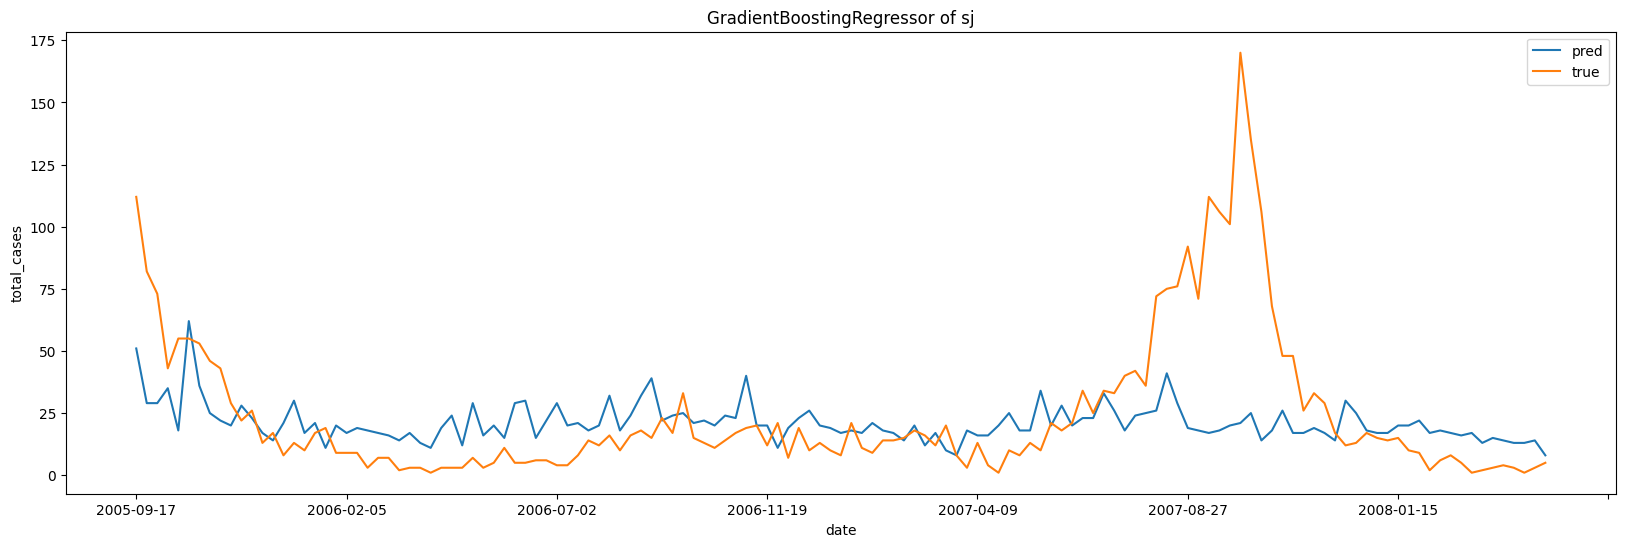

In [74]:
time=[i[2] for i in list(sj_train_subtest.index)]
time_trend=pd.DataFrame()
time_trend['pred']=best_pred
time_trend['true']=list(y_test)
time_trend.index=time
time_trend['pred'].plot(figsize=(20,6))
time_trend['true'].plot(figsize=(20,6))
plt.xlabel('date')
plt.ylabel('total_cases')
plt.title('GradientBoostingRegressor of sj')
plt.legend()
plt.show()

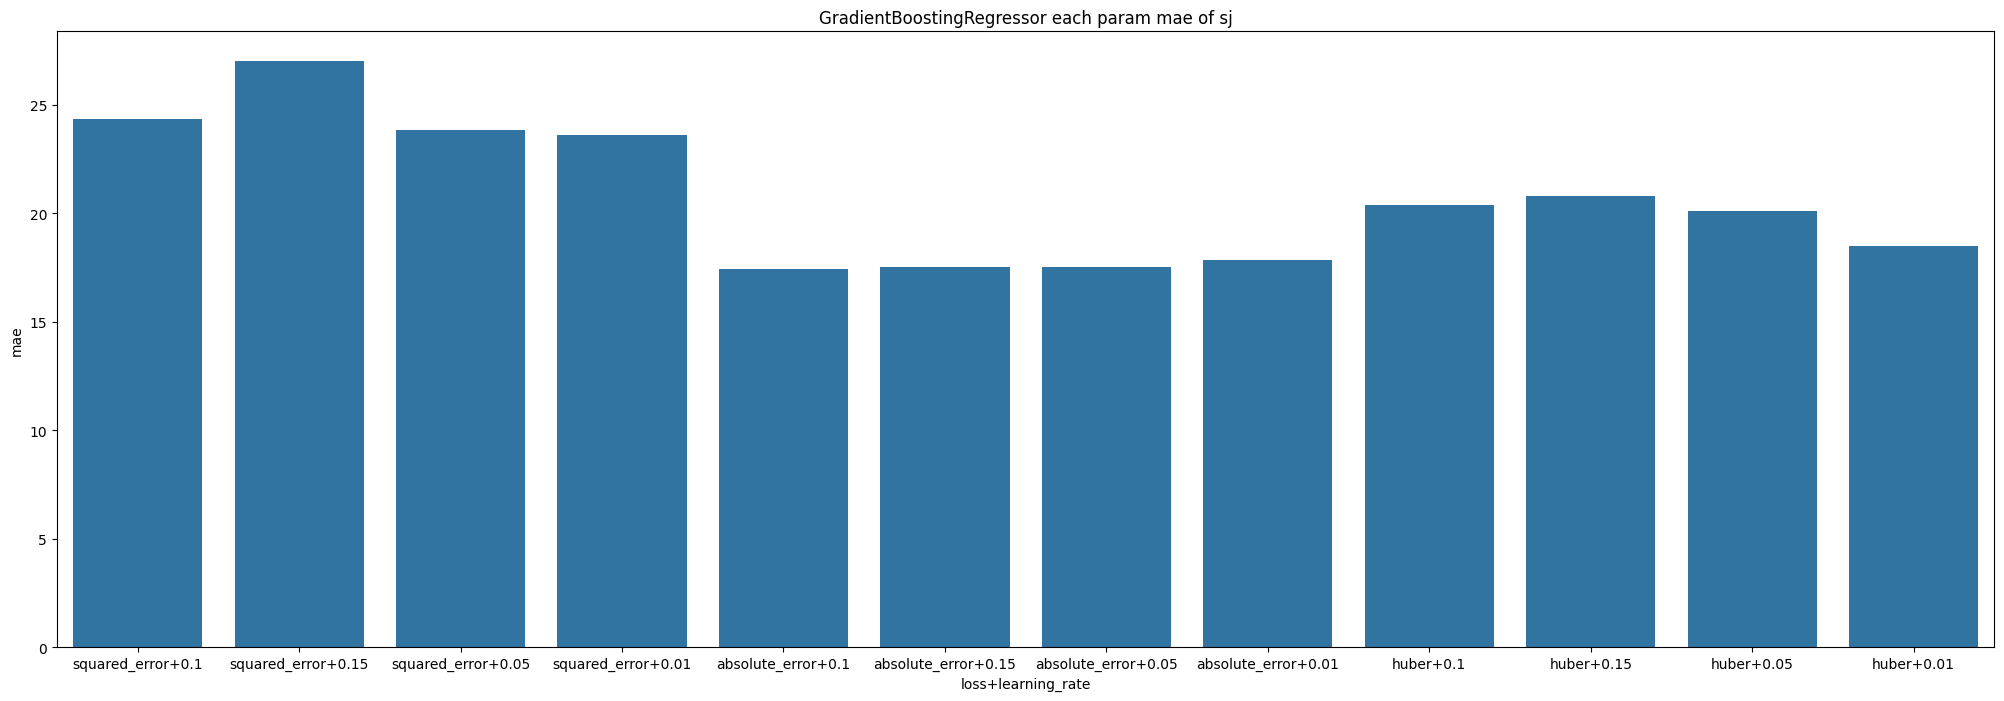

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in maes],y=[i[1] for i in maes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mae')
plt.title('GradientBoostingRegressor each param mae of sj')
plt.show()

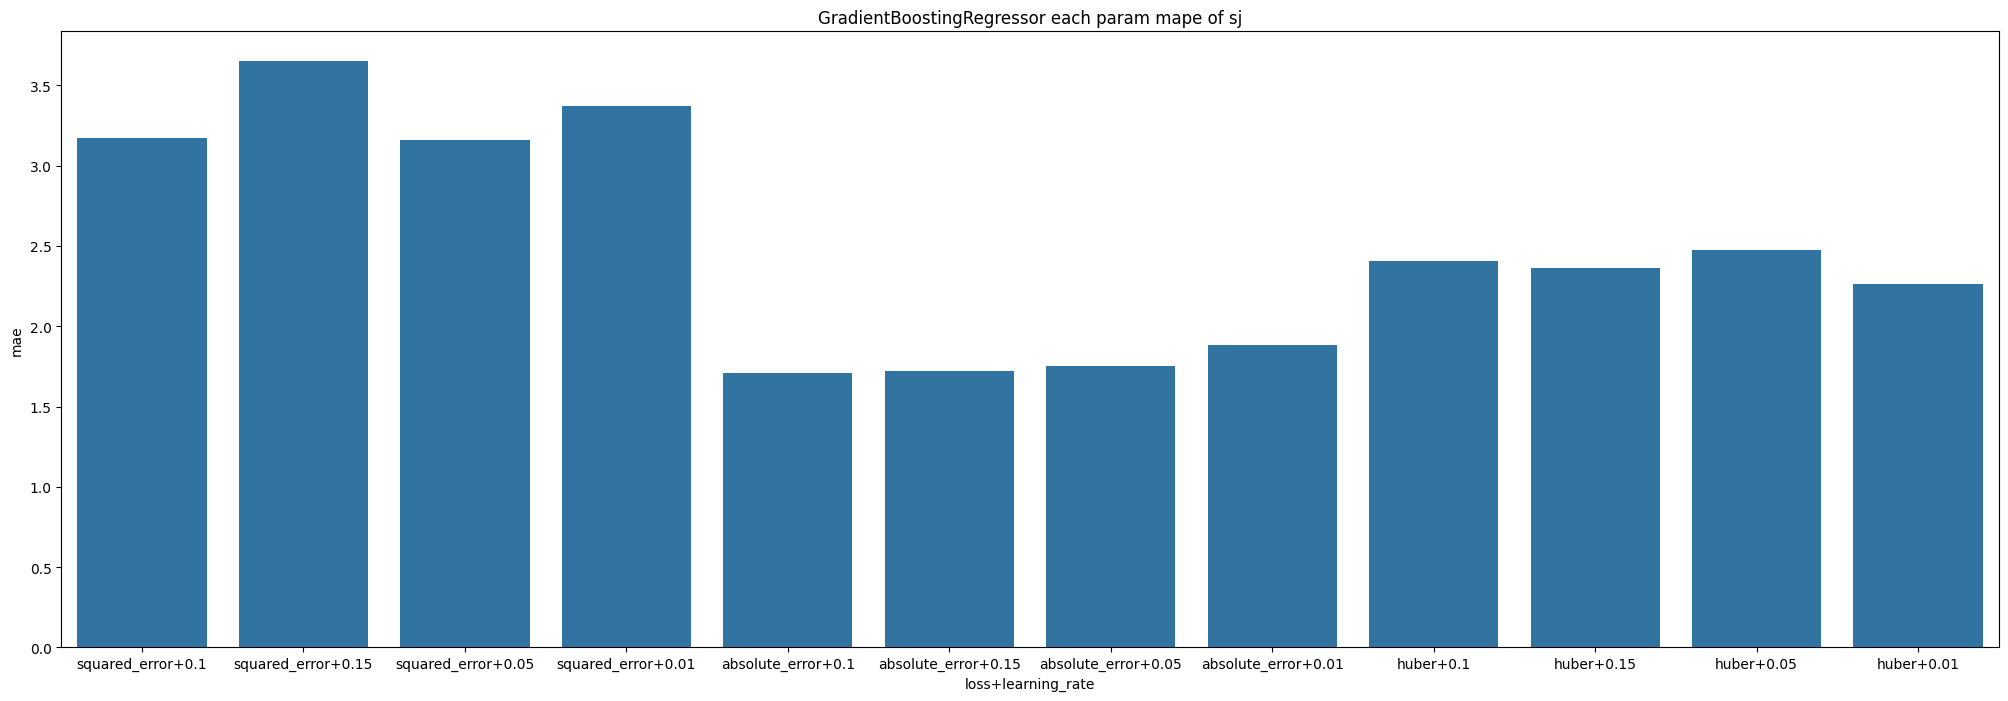

In [76]:
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in mapes],y=[i[1] for i in mapes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mae')
plt.title('GradientBoostingRegressor each param mape of sj')
plt.show()

In [77]:
# Extract the parameter columns
X_train = iq_train_subtrain[features]

# Extract the label column
y_train = iq_train_subtrain['total_cases']

# Extract the parameter columns
X_test = iq_train_subtest[features]

# Extract the label column
y_test = iq_train_subtest['total_cases']

In [78]:
maes,mapes,best_iq_mae_gbt,best_iq_mape_gbt,best_pred=main(X_train, y_train, X_test, y_test)

33 0 6.302752293577981
63 1 9.431192660550458
1.5028069309697352
30 0 6.155963302752293
63 1 9.431192660550458
1.5613968480558933
25 0 6.192660550458716
63 1 9.431192660550458
1.3578747391026567
12 5 7.027522935779817
63 1 9.431192660550458
1.4130257833104056
12 0 3.871559633027523
63 1 9.431192660550458
0.860823092404579
13 0 3.908256880733945
63 1 9.431192660550458
0.8862483187474935
12 0 3.9174311926605503
63 1 9.431192660550458
0.8522072359597128
11 2 4.412844036697248
63 1 9.431192660550458
0.8962008595590794
36 0 5.825688073394495
63 1 9.431192660550458
1.195017552520731
40 0 5.944954128440367
63 1 9.431192660550458
1.3529435095509852
33 1 5.8807339449541285
63 1 9.431192660550458
1.1290836343713002
14 3 5.779816513761468
63 1 9.431192660550458
1.095308215514745
Best Mean Absolute Error (MAE): 6.779816513761468
Best Mean Absolute PENCENTAGE Error (MAPE): 0.8522072359597128


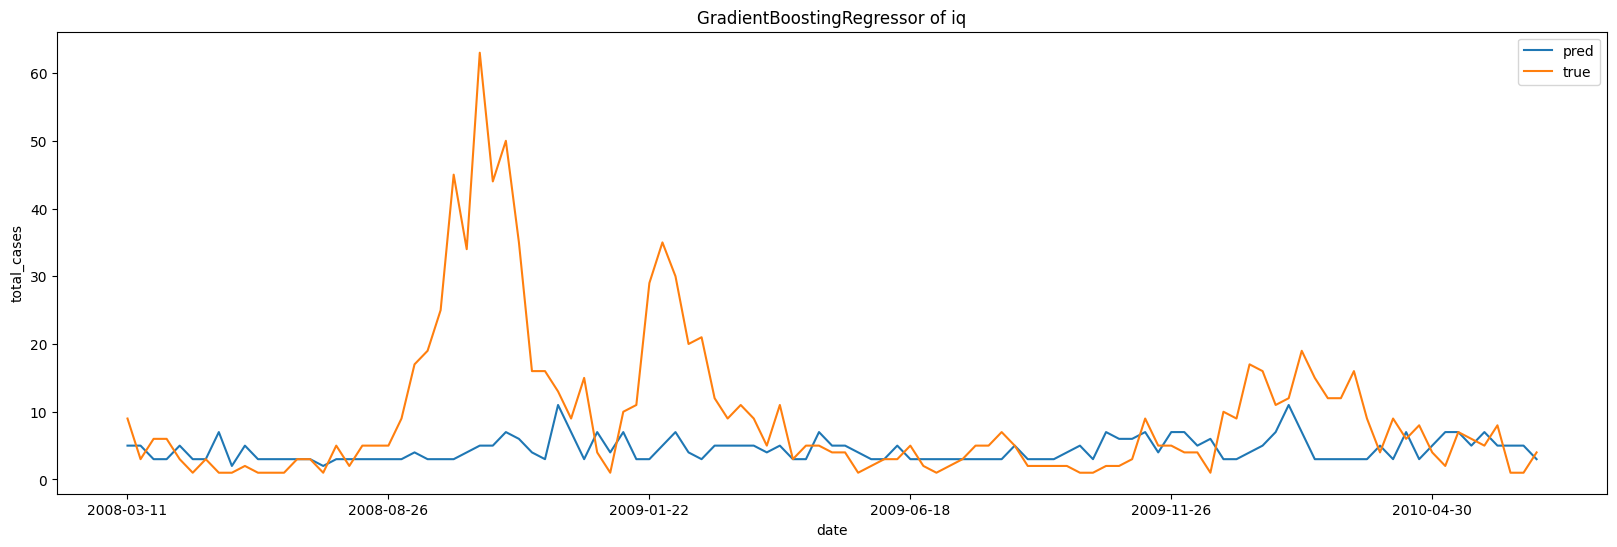

In [79]:
time=[i[2] for i in list(iq_train_subtest.index)]
time_trend=pd.DataFrame()
time_trend['pred']=best_pred
time_trend['true']=list(y_test)
time_trend.index=time
time_trend['pred'].plot(figsize=(20,6))
time_trend['true'].plot(figsize=(20,6))
plt.xlabel('date')
plt.ylabel('total_cases')
plt.title('GradientBoostingRegressor of iq')
plt.legend()
plt.show()

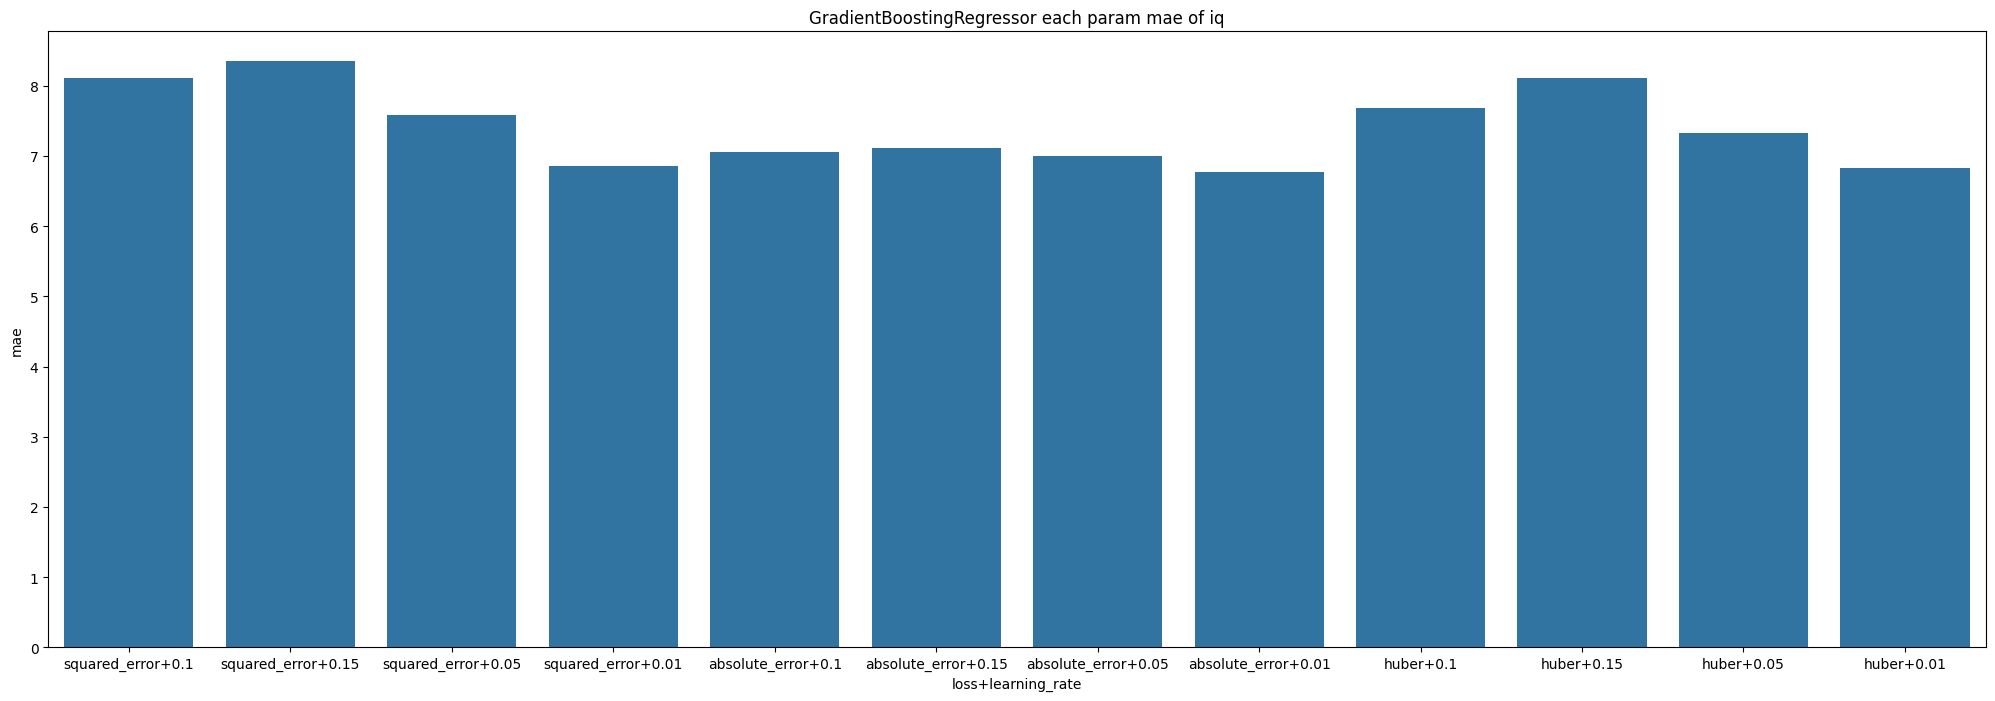

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in maes],y=[i[1] for i in maes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mae')
plt.title('GradientBoostingRegressor each param mae of iq')
plt.show()

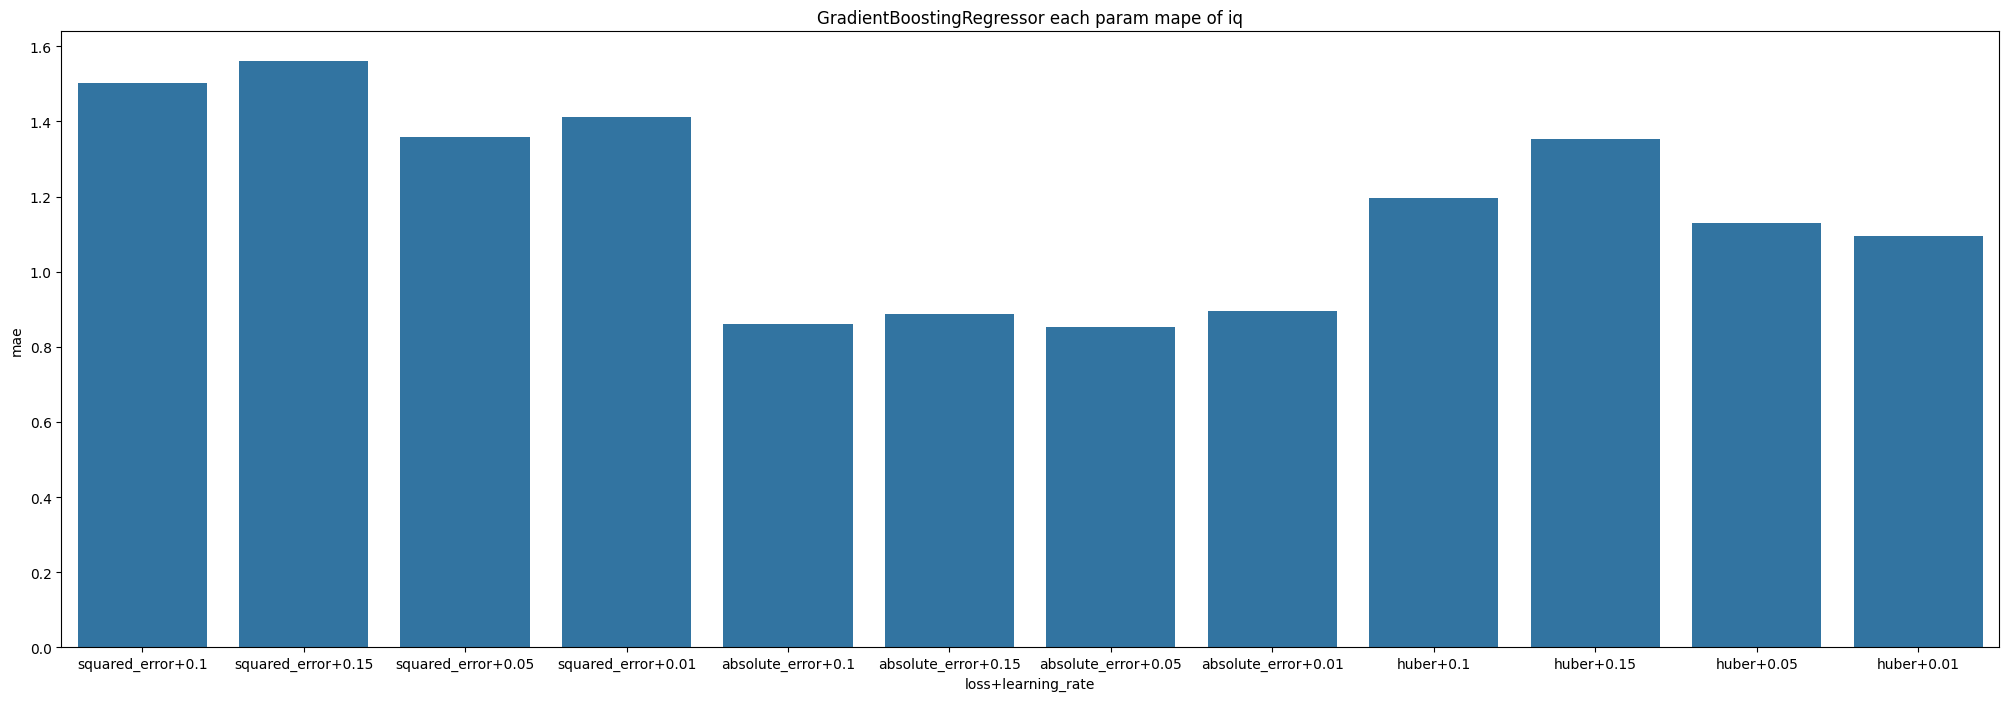

In [81]:
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in mapes],y=[i[1] for i in mapes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mae')
plt.title('GradientBoostingRegressor each param mape of iq')
plt.show()

# AdaBoostRegressor

In [82]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np

def main(X_train, y_train, X_test, y_test):
    # scale
    maes=[]
    mapes=[]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # grid search
    loss_params = ['linear', 'square', 'exponential']
    lr_params = [0.1, 0.15, 0.05, 0.01]
    best_mae = 1000
    best_mape=1000
    best_pred=1000
    for loss in loss_params:
        for lr in lr_params:
            # build AdaBoost Regressor model
            model = AdaBoostRegressor(loss=loss, learning_rate=lr)

            model.fit(X_train, y_train)

            # testing
            y_pred = model.predict(X_test)
            y_pred[y_pred<0] = 0
            y_pred = np.round(y_pred).astype(int)

            print(np.max(y_pred),np.min(y_pred),np.mean(y_pred))
            print(np.max(y_test),np.min(y_test),np.mean(y_test))
            
            # compute MAE  
            mae = mean_absolute_error(y_test, y_pred) 
            mape = mean_absolute_percentage_error(y_test, y_pred) 
            maes.append([loss+'+'+str(lr),mae])
            mapes.append([loss+'+'+str(lr),mape])
            if mae < best_mae:
                best_mae = mae
                best_pred=y_pred
            if mape < best_mape:
                best_mape = mape
    print(f'Best Mean Absolute Error (MAE): {best_mae}')
    print(f'Best Mean Absolute PENCENTAGE Error (MAPE): {best_mape}')
    return maes,mapes,best_mae,best_mape,best_pred

In [83]:
# Extract the parameter columns
X_train = sj_train_subtrain[features]

# Extract the label column
y_train = sj_train_subtrain['total_cases']

# Extract the parameter columns
X_test = sj_train_subtest[features]

# Extract the label column
y_test = sj_train_subtest['total_cases']

In [84]:
maes,mapes,best_sj_mae_ad,best_sj_mape_ad,best_pred=main(X_train, y_train, X_test, y_test)

129 20 45.03703703703704
170 1 24.45925925925926
148 20 47.87407407407407
170 1 24.45925925925926
113 20 40.37777777777778
170 1 24.45925925925926
98 18 34.2962962962963
170 1 24.45925925925926
153 18 48.474074074074075
170 1 24.45925925925926
162 20 59.46666666666667
170 1 24.45925925925926
138 18 42.31111111111111
170 1 24.45925925925926
72 17 34.22222222222222
170 1 24.45925925925926
131 18 44.71851851851852
170 1 24.45925925925926
135 22 49.28888888888889
170 1 24.45925925925926
92 18 38.88148148148148
170 1 24.45925925925926
103 17 33.82962962962963
170 1 24.45925925925926
Best Mean Absolute Error (MAE): 21.57777777777778
Best Mean Absolute PENCENTAGE Error (MAPE): 2.988971236304604


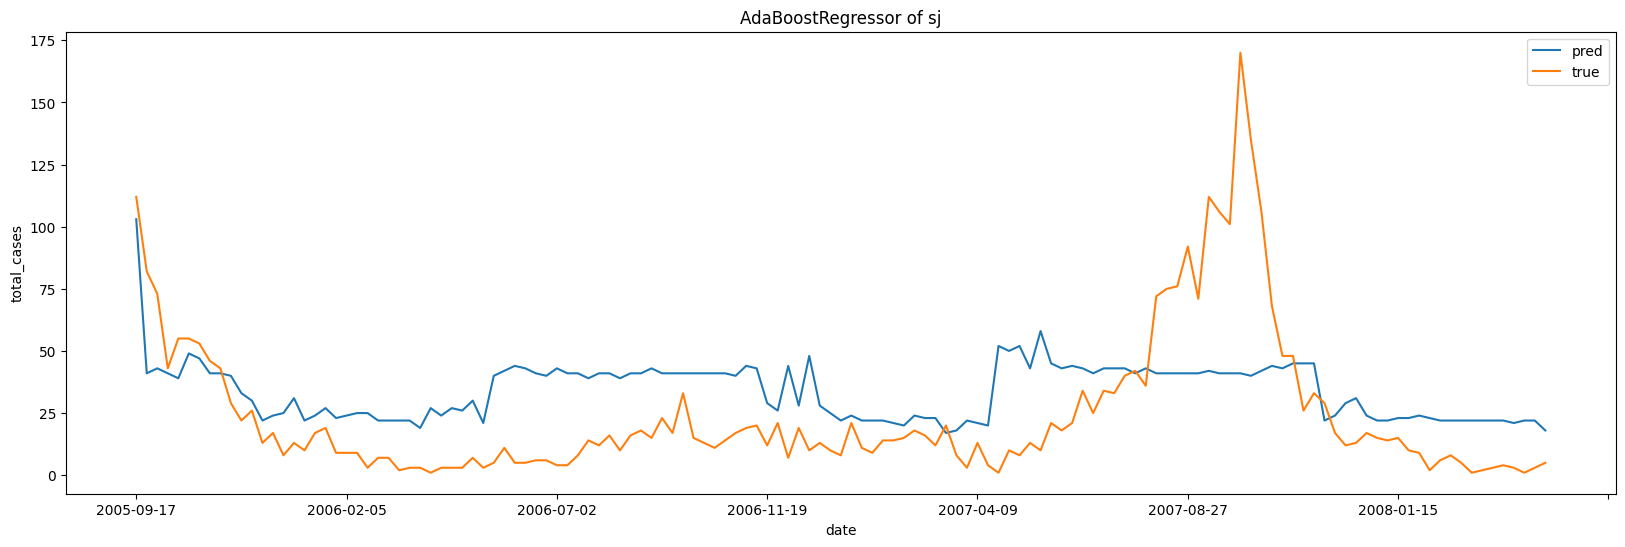

In [85]:
time=[i[2] for i in list(sj_train_subtest.index)]
time_trend=pd.DataFrame()
time_trend['pred']=best_pred
time_trend['true']=list(y_test)
time_trend.index=time
time_trend['pred'].plot(figsize=(20,6))
time_trend['true'].plot(figsize=(20,6))
plt.xlabel('date')
plt.ylabel('total_cases')
plt.title('AdaBoostRegressor of sj')
plt.legend()
plt.show()

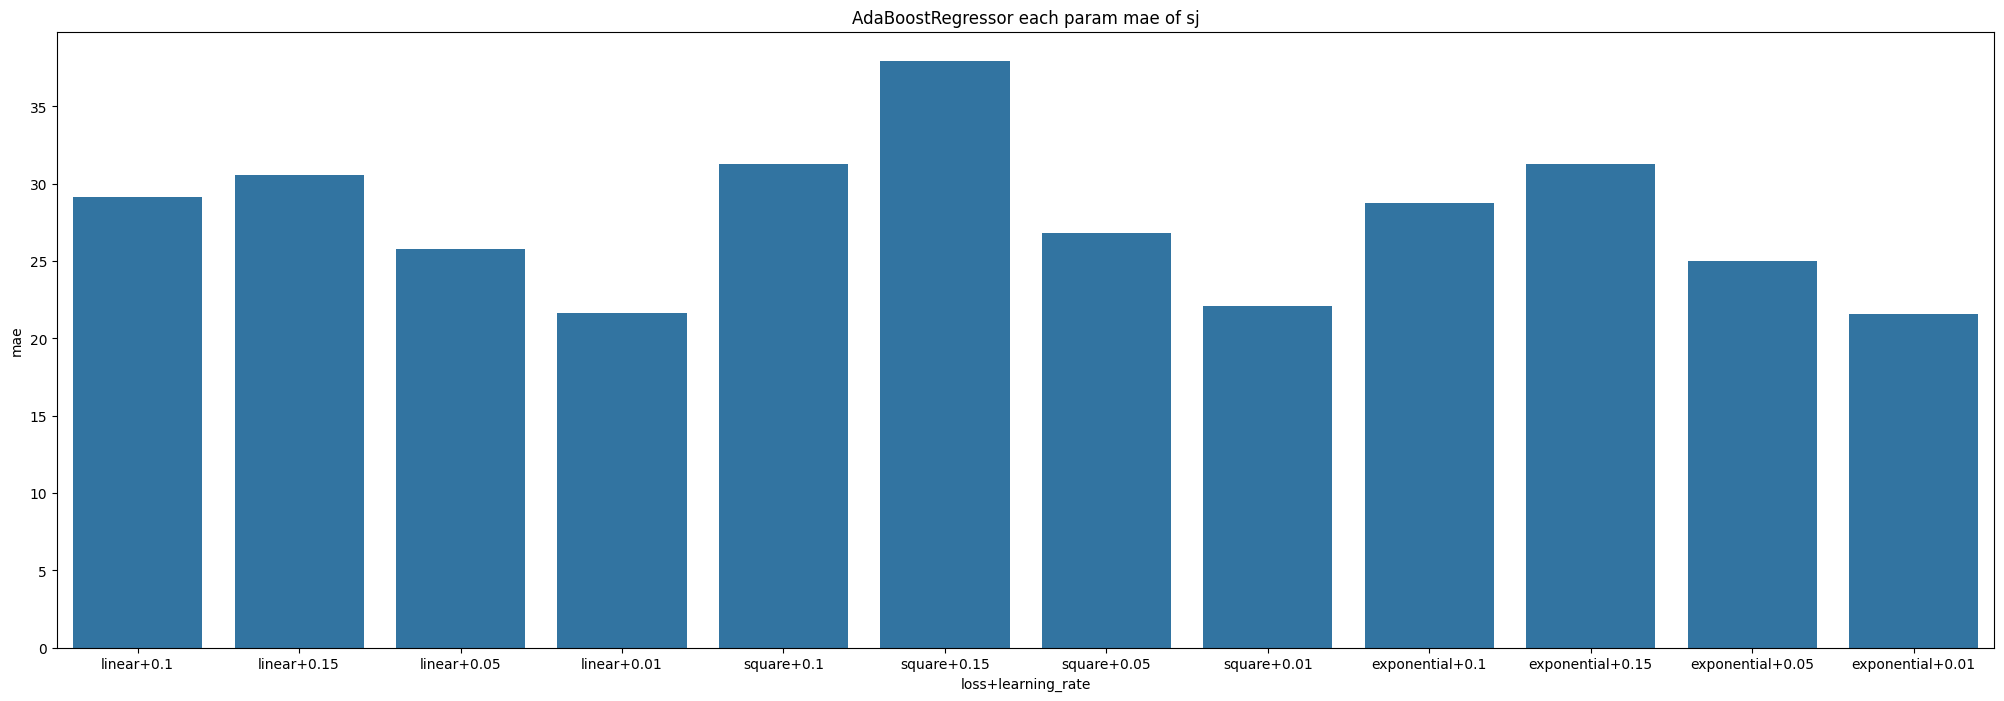

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in maes],y=[i[1] for i in maes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mae')
plt.title('AdaBoostRegressor each param mae of sj')
plt.show()

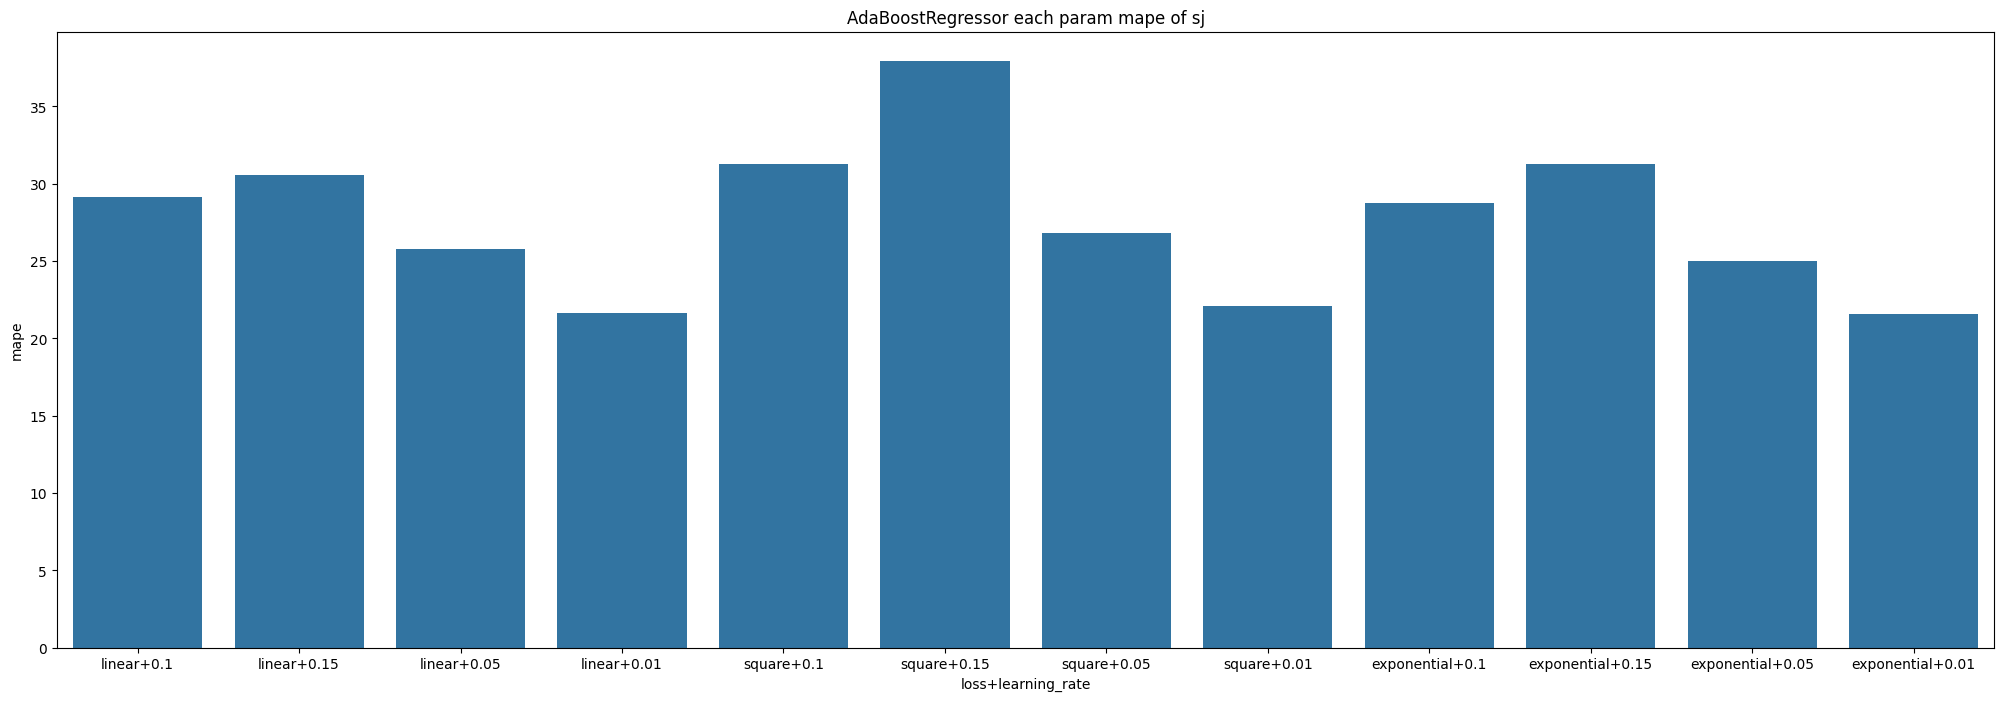

In [87]:
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in maes],y=[i[1] for i in maes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mape')
plt.title('AdaBoostRegressor each param mape of sj')
plt.show()

In [88]:
# Extract the parameter columns
X_train = iq_train_subtrain[features]

# Extract the label column
y_train = iq_train_subtrain['total_cases']

# Extract the parameter columns
X_test = iq_train_subtest[features]

# Extract the label column
y_test = iq_train_subtest['total_cases']

In [89]:
maes,mapes,best_iq_mae_ad,best_iq_mape_ad,best_pred=main(X_train, y_train, X_test, y_test)

24 3 7.752293577981652
63 1 9.431192660550458
33 3 8.20183486238532
63 1 9.431192660550458
23 3 7.045871559633028
63 1 9.431192660550458
15 3 6.293577981651376
63 1 9.431192660550458
36 3 7.394495412844036
63 1 9.431192660550458
44 3 7.192660550458716
63 1 9.431192660550458
20 3 6.981651376146789
63 1 9.431192660550458
15 3 6.201834862385321
63 1 9.431192660550458
27 3 7.862385321100917
63 1 9.431192660550458
25 3 8.229357798165138
63 1 9.431192660550458
21 3 7.08256880733945
63 1 9.431192660550458
15 3 6.137614678899083
63 1 9.431192660550458
Best Mean Absolute Error (MAE): 6.73394495412844
Best Mean Absolute PENCENTAGE Error (MAPE): 1.1613513618940905


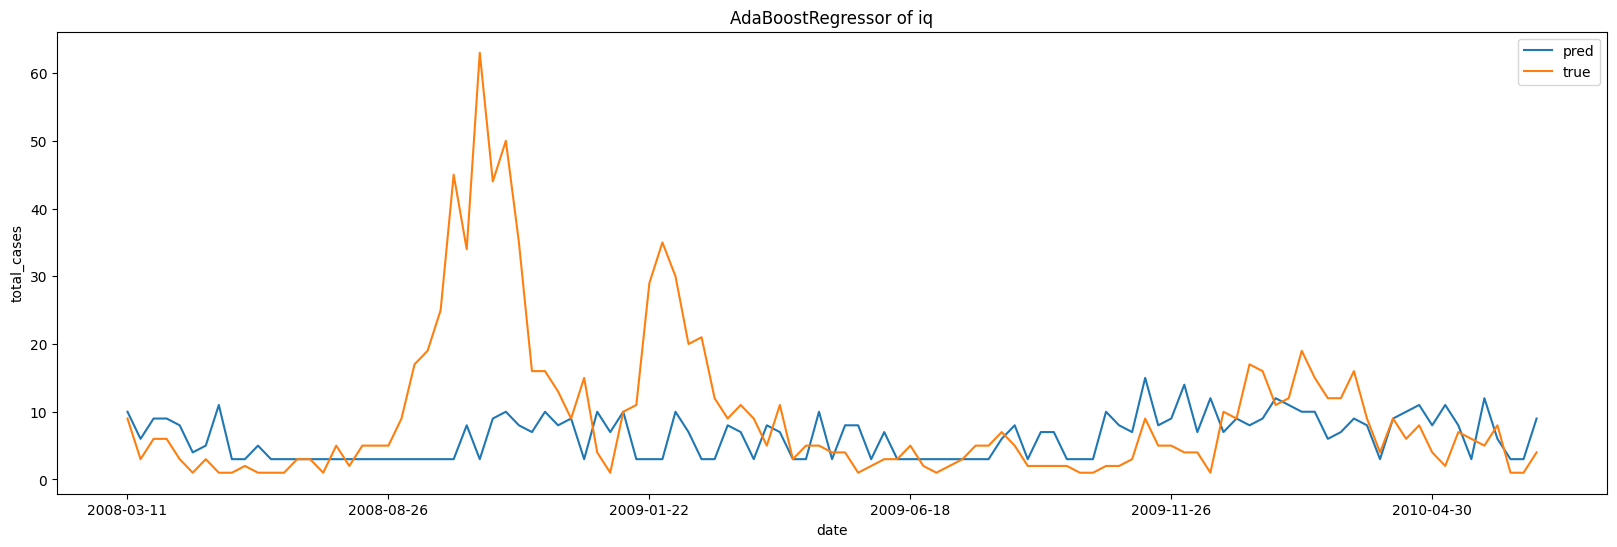

In [90]:
time=[i[2] for i in list(iq_train_subtest.index)]
time_trend=pd.DataFrame()
time_trend['pred']=best_pred
time_trend['true']=list(y_test)
time_trend.index=time
time_trend['pred'].plot(figsize=(20,6))
time_trend['true'].plot(figsize=(20,6))
plt.xlabel('date')
plt.ylabel('total_cases')
plt.title('AdaBoostRegressor of iq')
plt.legend()
plt.show()

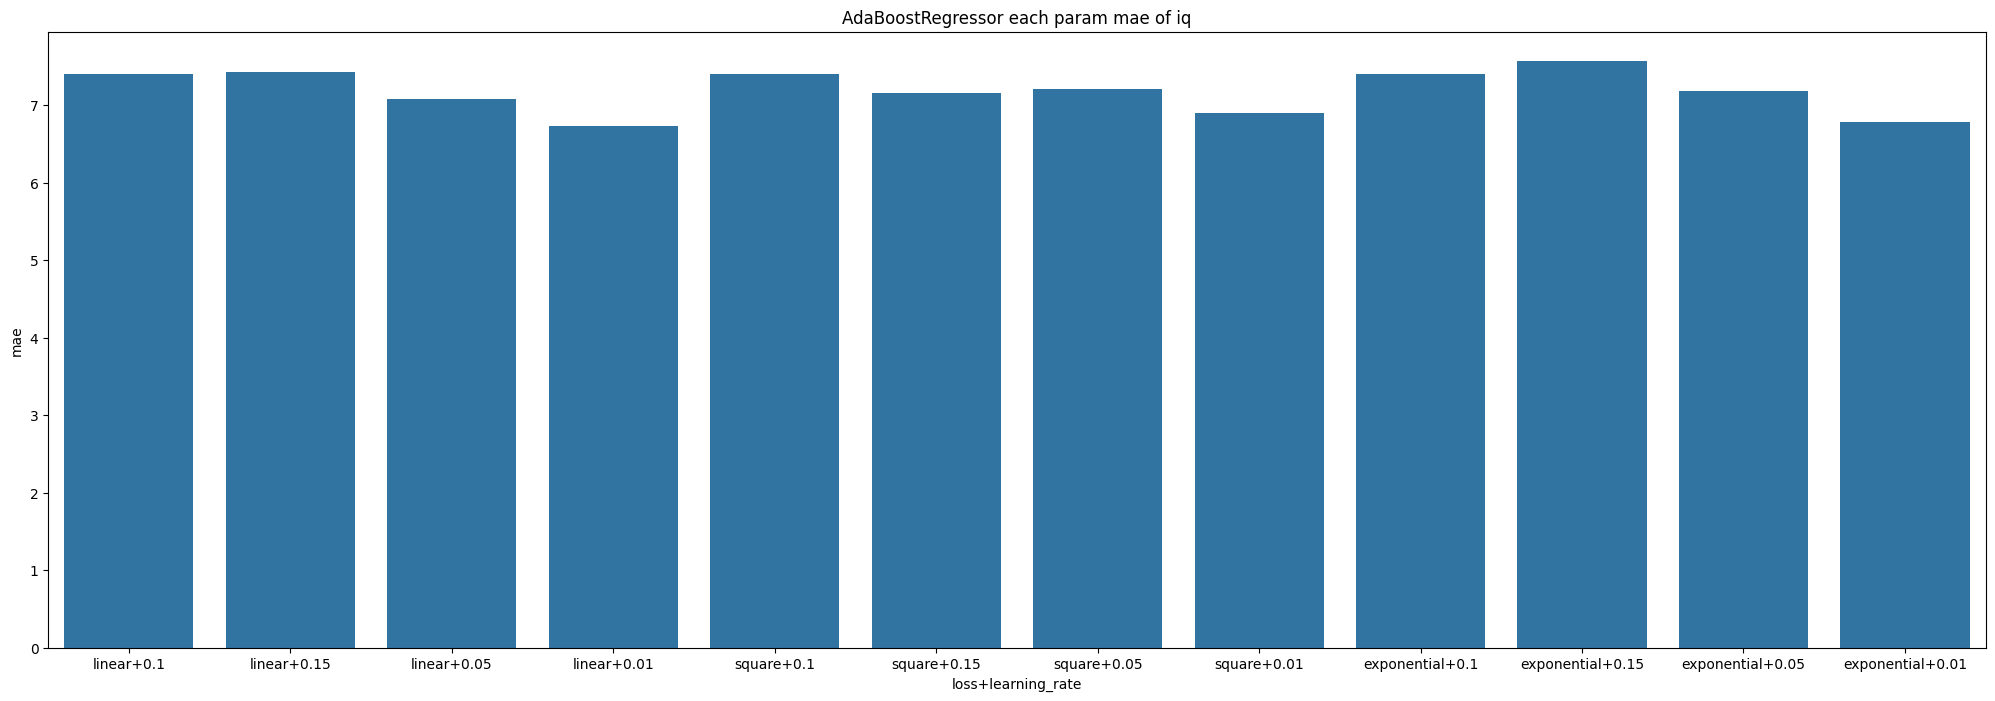

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in maes],y=[i[1] for i in maes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mae')
plt.title('AdaBoostRegressor each param mae of iq')
plt.show()

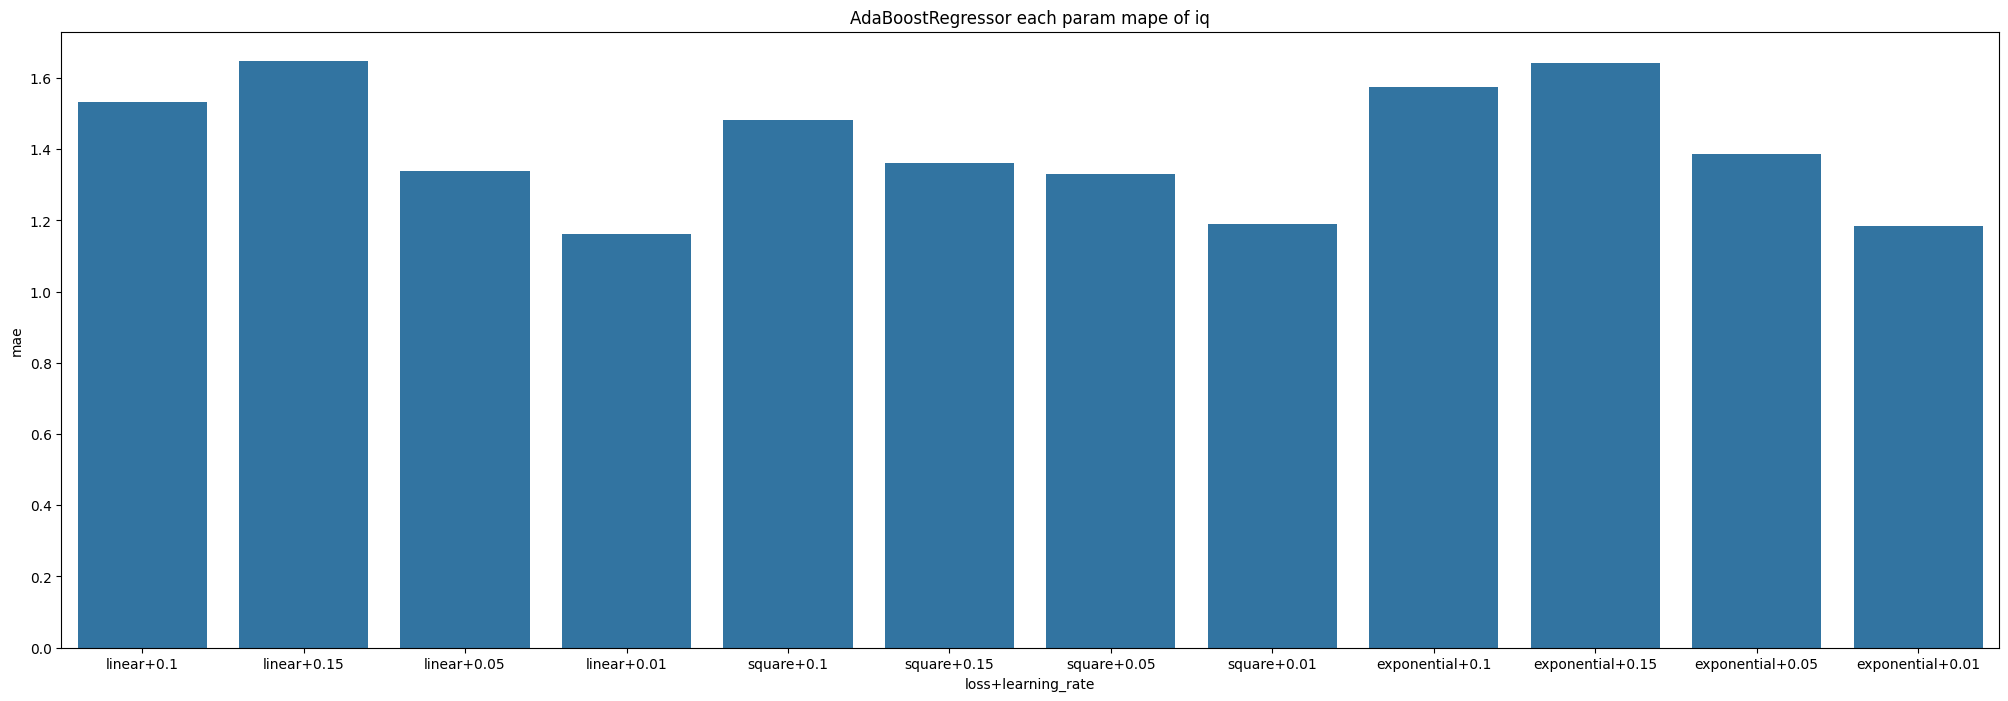

In [92]:
plt.figure(figsize=(25,8))
sns.barplot(x=[i[0] for i in mapes],y=[i[1] for i in mapes])
plt.xlabel('loss+learning_rate')
plt.ylabel('mae')
plt.title('AdaBoostRegressor each param mape of iq')
plt.show()

# BEST THREE MODEL COMPARE

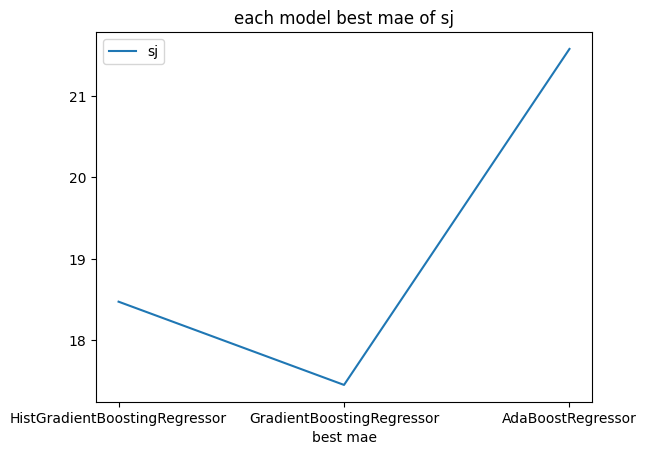

In [93]:
sns.lineplot(x=['HistGradientBoostingRegressor','GradientBoostingRegressor','AdaBoostRegressor'],y=[best_sj_mae_hist,best_sj_mae_gbt,best_sj_mae_ad],label='sj')

plt.xlabel('model')
plt.xlabel('best mae')
plt.title('each model best mae of sj')
plt.legend()
plt.show()

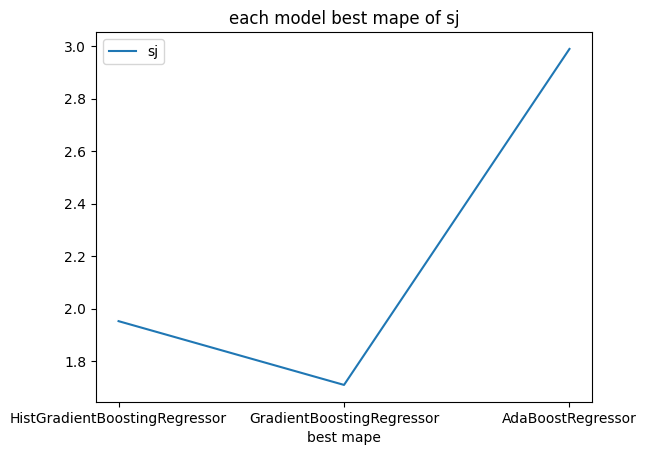

In [94]:
sns.lineplot(x=['HistGradientBoostingRegressor','GradientBoostingRegressor','AdaBoostRegressor'],y=[best_sj_mape_hist,best_sj_mape_gbt,best_sj_mape_ad],label='sj')

plt.xlabel('model')
plt.xlabel('best mape')
plt.title('each model best mape of sj')
plt.legend()
plt.show()

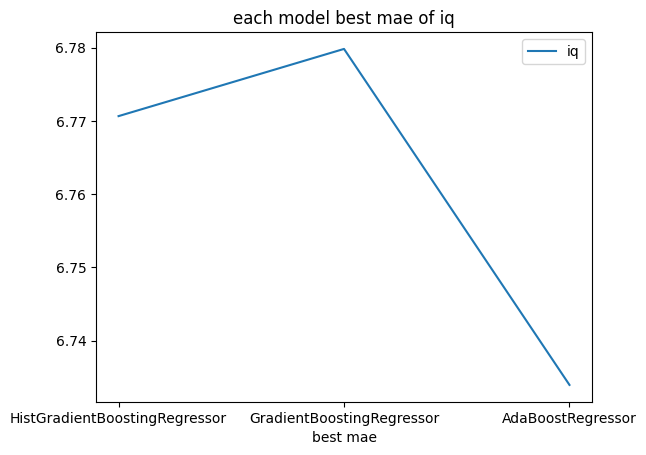

In [95]:
sns.lineplot(x=['HistGradientBoostingRegressor','GradientBoostingRegressor','AdaBoostRegressor'],y=[best_iq_mae_hist,best_iq_mae_gbt,best_iq_mae_ad],label='iq')

plt.xlabel('model')
plt.xlabel('best mae')
plt.title('each model best mae of iq')
plt.legend()
plt.show()

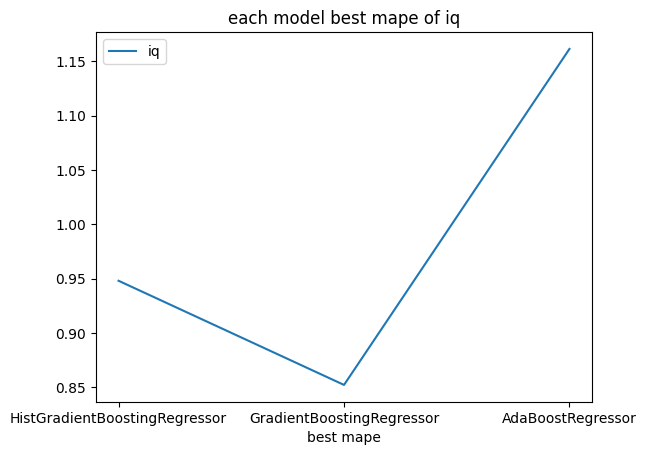

In [96]:
sns.lineplot(x=['HistGradientBoostingRegressor','GradientBoostingRegressor','AdaBoostRegressor'],y=[best_iq_mape_hist,best_iq_mape_gbt,best_iq_mape_ad],label='iq')

plt.xlabel('model')
plt.xlabel('best mape')
plt.title('each model best mape of iq')
plt.legend()
plt.show()